In [1]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

from sklearn.metrics import pairwise_distances
import lxml.etree
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, \
                            precision_recall_curve, average_precision_score, \
                            roc_auc_score

import seaborn as sb
sb.set(font_scale=.6)
import matplotlib.pyplot as plt
plt.style.use('grayscale')
sb.set_style("white")
sb.set_palette("Greys_r")

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.cmap'] = 'Greys_r'

from matplotlib.font_manager import FontProperties
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Roboto Condensed']
from IPython.display import display

## Loading and preprocessing

We create a directory for saving the figures if required:

In [2]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

We load the spreadsheet which holds the tabular overview of the annotated intertexts:

In [3]:
intertexts = pd.read_excel('../data/intertexts.xlsx')
print(len(intertexts), 'annotated in total')
intertexts.sample(5)

229 annotated in total


,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks
97,mor-mou-16,Moriaen,Hie deetse bat achtergaen.,Riddere metter mouwen,Ende dadense also achtergaen.,1,Van der Stempel 1930,Editions have achterstaen. Might not be a link.
145,lan-ele-21,Lantsloot van der Haghedochte,Mar ic segghe v dat ic v rade Omme te bescuwene meere scade:,Moriaen,oft gi werken wilt bi rade Ende scuwen wilt vwe scade.,2,"Heeroma 1973b, Moriaen (II)",NaN
8,mor-ele-9,Moriaen,God hi mach v wel gesterken.,Karel ende Elegast,Nv so moetti - God - mi gestercken:,1,"Heeroma 1973a, Moriaen (I)",NaN
84,mor-mou-4,Moriaen,Doe hi achters van u sciet,Riddere metter mouwen,Doe hi achters van hem sciet,1,Van der Stempel 1917,Double case
25,mor-ele-26,Moriaen,En ontfinc noit vlecge no scard.,Karel ende Elegast,Ende ontfingen scarde ende vlegghen:,1,"Heeroma 1973a, Moriaen (I)",NaN


Each row documents one attestation of an intertext in a pair of texts, with for every instance:
- an `ID`, which is not unique, becomes the same intertext can be attested multiple times (i.e. for different document pairs);
- the title of the `source` text and the `target` text (one of the four texts considered: *Lantsloot van der Hagedochte*, *Moriaen*, *Riddere metter mouwen*, *Karel ende Elegast*). Note that the direction of the intertext (cf. source vs target) is not material in what follows;
- the actual passage in the source and target text (`src-passage` and `trg-passage`) quoted in the referenced publication; in the XML data (see "data/xml") the suggested annotation has been encoded at the level of entire verse line;
- the approximate length of the match expressed in the number of verse lines involved;
- a bibliographical reference for the intertext (`biblio`);
- potentially, some (informal) `remarks`, which can be safely disregarded.

While this spreadsheet holds a useful overview, the intertexts have also been manually encoded in the XML files in the `data/xml` directory in this repository, using an `intertext` attribute at the verse level that holds the corresponding `ID` of the row in the spreadsheet. For instance, in the *Elegast*:

```xml
  <l n="13" tokens="Crone draghen ende houden hof" intertext="mor-ele-2">
    ...
  </l>
  <l n="14" tokens="Om te meerderen sinen lof" intertext="mor-ele-2">
    ...
  </l>
```

We can plot the length distribution (in verse lines) of the intertexts:

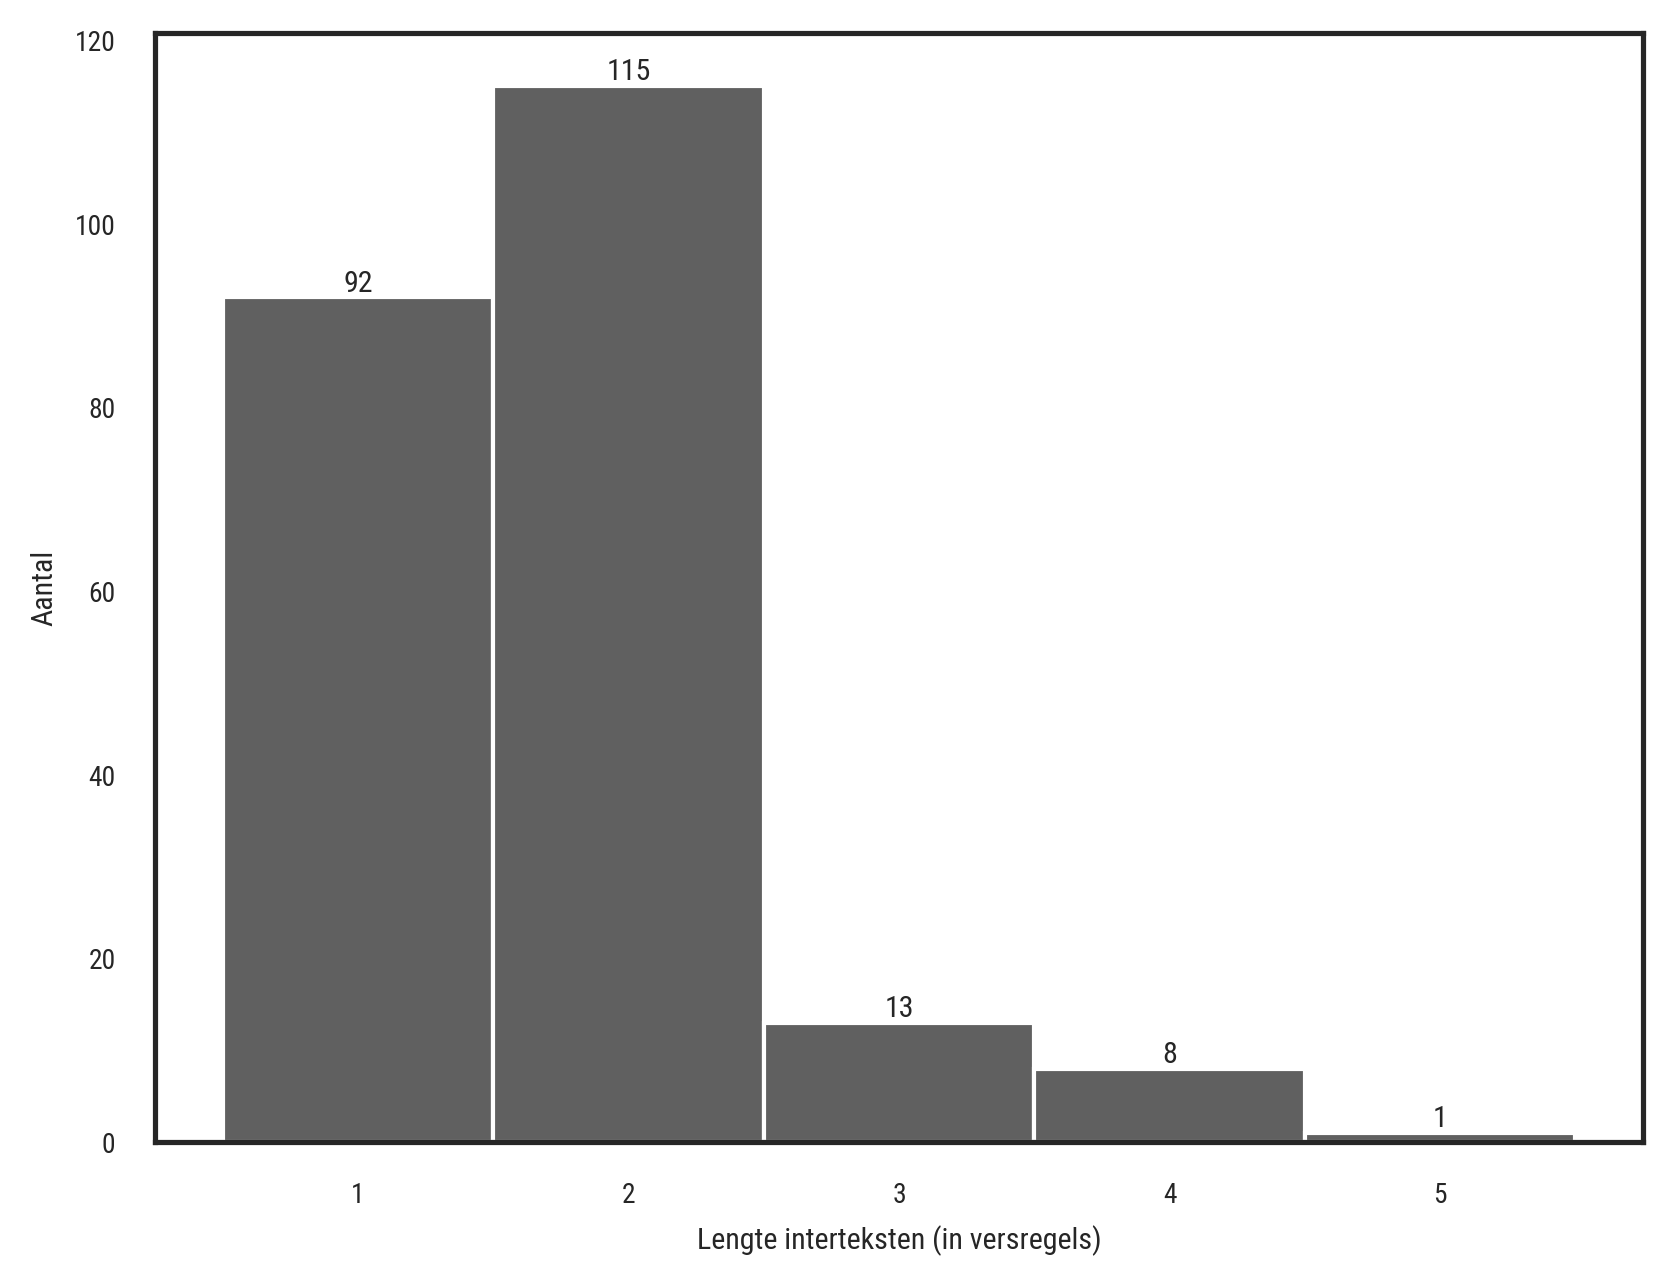

In [4]:
ax = sb.histplot(data=intertexts, x='verse-length', discrete=True)

heights = [p.get_height() for p in ax.patches]

for i, height in enumerate(heights):
    x_pos = ax.patches[i].get_x() + ax.patches[i].get_width()/2
    
    ax.text(x_pos, height, 
            str(int(height)),
            ha='center',
            va='bottom')

plt.xlabel('Lengte interteksten (in versregels)')
plt.ylabel('Aantal')
plt.savefig(f'{fig_dir}/intertext_dist.png')

The annotated intertexts are comparatively short (1-2 lines).

Below, we plot the number of absolute intertexts available across all text pairs (which are far from symmetric):

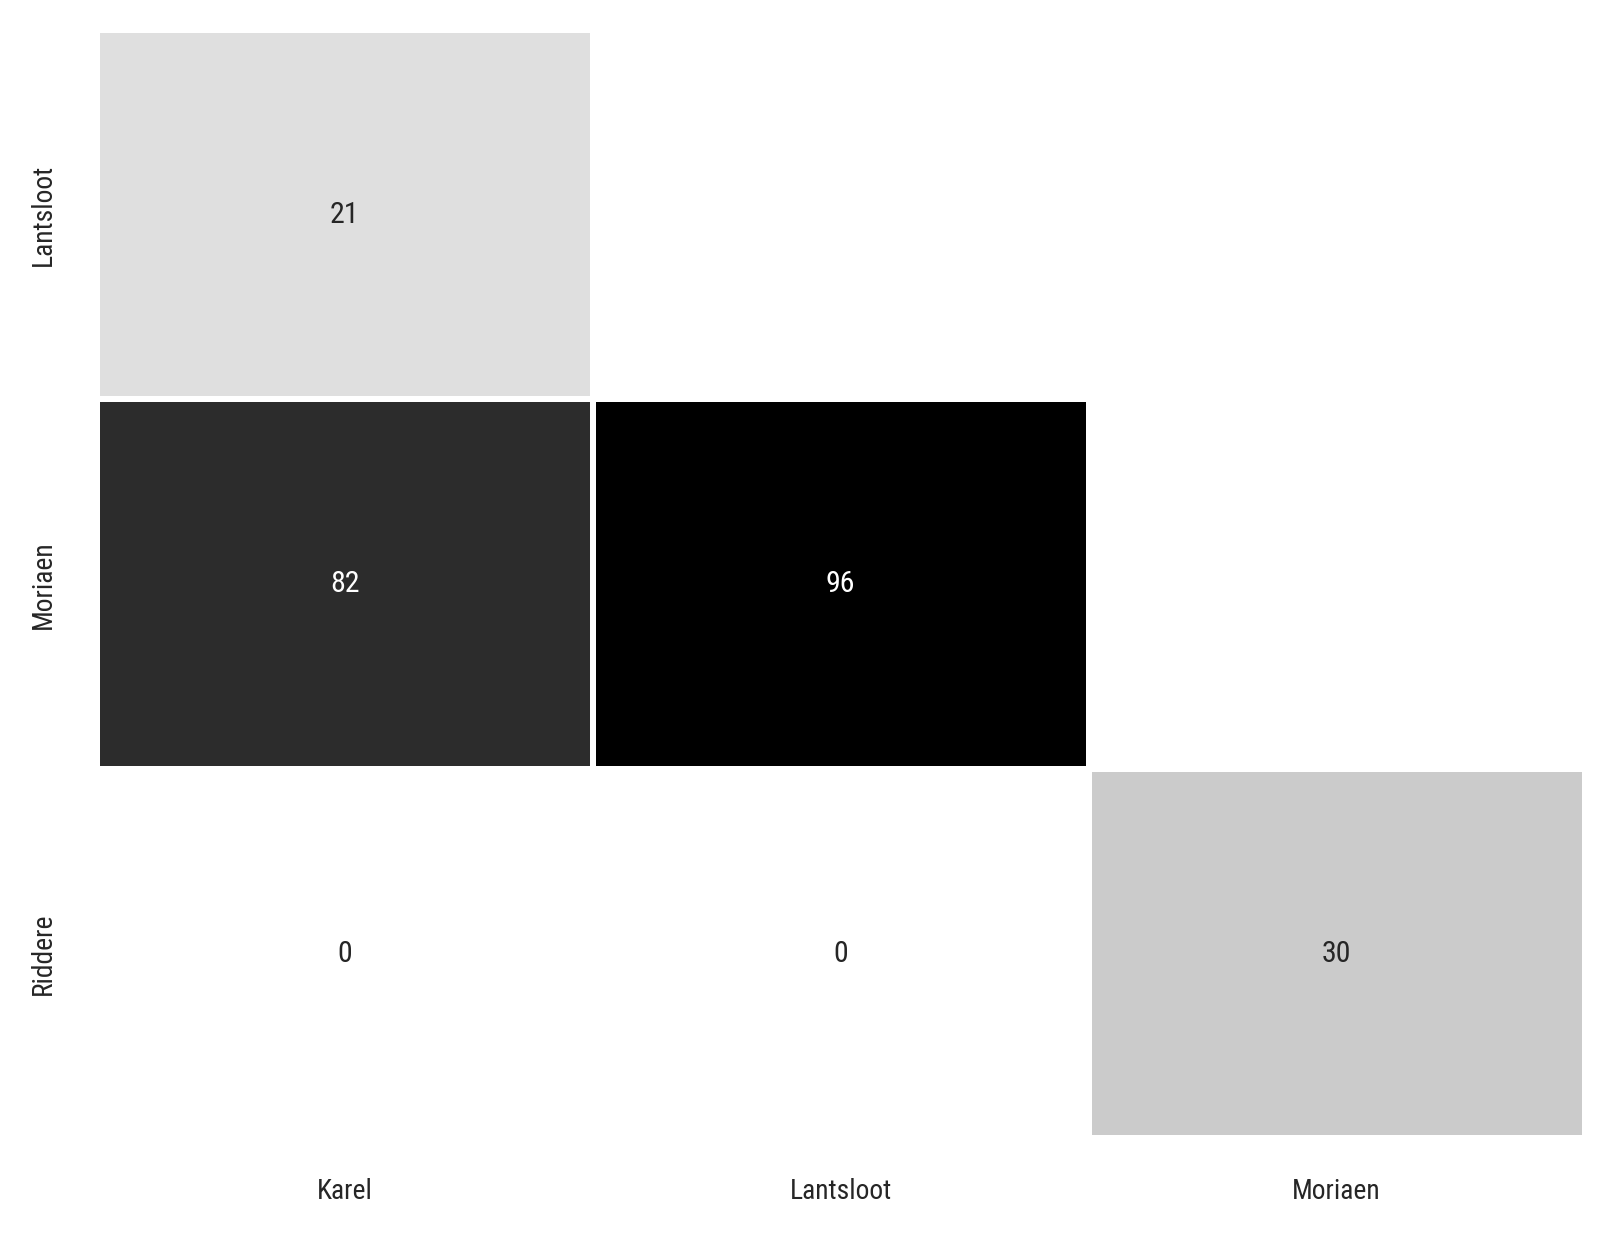

In [5]:
titles = sorted(set(intertexts['source'].tolist() + intertexts['target'].tolist()))
counts = np.zeros((len(titles), len(titles)))
for _, row in intertexts.iterrows():
    counts[titles.index(row['source']), titles.index(row['target'])] += 1
    counts[titles.index(row['target']), titles.index(row['source'])] += 1
np.fill_diagonal(counts, np.nan)
counts[np.triu_indices(4)] = np.nan
titles = [t.split()[0] for t in titles]
counts = pd.DataFrame(counts, columns=titles, index=titles)
counts = counts.iloc[1:, :-1]
ax = sb.heatmap(counts, annot=True, cmap='Greys', cbar=False, linewidths=1, linecolor='white')
ax.tick_params(left=False, bottom=False)
for l in plt.gca().lines:
    l.set_alpha(0.3)
plt.savefig(f'{fig_dir}/intertext_links.png');

#### Load metadata

We now load the metadata at the level of the XML files:

In [6]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,provenance,date_range,genre,subgenre,exclude
9,barlaam_en_josaphat_fragm_ge,Barlaam en Josaphat,NaN,cdrom-mnl,1300-1350,Epiek,Ridder,NaN
276,roman_van_walewein_vostaert,Walewein (Vostaert),Pieter Vostaert,cdrom-mnl,1350-1350,Epiek,Arthur,NaN
217,spiegel_historiael__2_fragm_ge1,Spiegel historiael (P2),Philip Utenbroeke,cdrom-mnl,1390-1410,Epiek,Historiografie,NaN
120,madelgijs_fragm_lo,Madelgijs,NaN,cdrom-mnl,1350-1400,Epiek,Karel,NaN
37,collectief_lunarium_ii,Collectief lunarium II,NaN,cdrom-mnl,1434-1436,Epiek,Didactiek,NaN
174,rijmkroniek_van_holland,Rijmkroniek van Holland,Melis Stoke,cdrom-mnl,1365-1385,Epiek,Historiografie,NaN
35,collectief_lunarium_iii,Collectief lunarium III,NaN,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
256,van_den_vos_reynaerde,Van den vos Reynaerde,Willem,cdrom-mnl,1380-1425,Epiek,Dier,NaN
72,gedichten_hildegaersberch__hs_g,Gedichten (Willem van Hildegaersberch),Willem van Hildegaersberch,cdrom-mnl,1470-1490,Lyriek,NaN,NaN
253,van_den_verkeerden_martijn,Van den verkeerden Martijn,Jacob van Maerlant,cdrom-mnl,1339-1339,Lyriek,NaN,NaN


The principles behind this metdata were previously discussed in this paper:

> Vandyck, Caroline & Kestemont, Mike, ‘Een auteur van formaat. Een attributie-onderzoek naar het oeuvre van de Limborch-dichter’. *Spiegel der letteren* 66:2 (2024), 111-167 [[doi]](https://doi.org/10.2143/SDL.66.2.3293546).

Apart from the genre labels (which are of course fuzzy and difficult to assign), the appendix to this paper also documents the interpolations that we remove from the texts below and our selection and merging of the textual witness, if multiple are available for a specific work (see the "exclude" column). We parse the XML files, using the following utility functions:

In [7]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size - 1)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                # special case where multiple intertexts 
                # are present in the sale verse group
                yield 'overlap'
            else:
                yield list(its.keys())[0]

def parse_xml(fn, rm_interpol=False):
    try:
        tree = lxml.etree.parse(fn)
    except OSError:
        print(f'- Could not load {fn}')
        return None
    
    # we remove (non-authorial) interpolations from the XMLs:
    # see the appendix to Vandyck & Kestemont (2024)
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
        
    for line_node in tree.iterfind('.//l'):
        try:
            intertext_id = line_node.attrib['intertext']
        except KeyError:
            intertext_id = None
        
        tokens_ = line_node.attrib['tokens'].split()
        lemmas_ = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        lemmas_.append('n(prop)')
                    else:
                        lemmas_.append(l)
    
        yield tokens_, lemmas_, intertext_id

Some comments on this process:
- By default, we extract (overlapping) groups of two consecutive lines;
- When extracting intertexts, the iterator in `get_verse_groups` takes into account that, because of the sliding window approach, a verse group might yield an "overlap" if two intertexts are immediately adjacent;
- The lemmas for proper nouns are masked by replacing them with an 'n(prop)' symbol.

In [8]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(sorted(meta_df.groupby('title'))):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml/{id_}.xml'):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 205/205 [00:15<00:00, 13.31it/s]


We can now create a single, huge dataframe that has all the verse groups from the corpus, with a title, the original tokens, the lemmas (which we'll use for the matching) and the intertext which was annotated for them (if any):

In [9]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
# we ignore verse groups with ambiguous intertexts:
df = df[df['intertext'] != 'overlap']
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())].sample(10)

,title,tokens,lemmas,intertext
340540,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15
341067,Karel ende Elegast,Dies is leden die derde dach / Dat ic voer om mijn beiach,die zijn lijden de derde dag / dat ik varen om mijn bejag,mor-ele-44
341357,Karel ende Elegast,Elegast seyde wats mijns gheschiet / En come voor den coninc niet,n(prop) zeggen wat zijn ik geschieden / ne komen voor de koning niet,mor-ele-55
341607,Karel ende Elegast,So dat ic niet en sterue / Noch inden camp en bederue,zo dat ik niet ne sterven / noch in de kamp in bederf,mor-ele-74
341598,Karel ende Elegast,Van allen minen misdaden / Die mi ye gheuel,van al mijn misdaad / die ik ie gevallen,mor-ele-72
340630,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17
340467,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11
341393,Karel ende Elegast,Ter hoger tinnen blies den dach / Diemen scone verbaren sach,de te hoog tinnen blazen de dag / die men schoon verbranden zien,mor-ele-60
341266,Karel ende Elegast,Al om tgoet dat elegast brochte / Hine hadder niet langher gestaen,al om dat goed dat n(prop) brengen / hij ne er hebben niet lang staan,mor-ele-49
340722,Karel ende Elegast,Haer orssen sterc ende snel / Si waren beyde ghewapent wel,haar orssen sterk en snel / zij zijn beide gewapend wel,mor-ele-23


Below, we'll assign special weight to the rhyme words in texts, which often seem to have served as a special cue or additional trigger for recognizing intertexts in the past. We'll achieve by adding an extra column to our dataframe, that has just the verse-final lemmas of the rhyme words:

In [10]:
def add_rhyme_column(df):
    rhyme_words = []
    for lemmas in df['lemmas']:
        rhymes = []
        for verse in lemmas.split(' / '):
            rhymes.append(verse.strip().split()[-1])
        rhyme_words.append(' '.join(rhymes))
    df['rhyme'] = rhyme_words
    return df

df = add_rhyme_column(df)
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())].sample(10)

,title,tokens,lemmas,intertext,rhyme
340465,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10,land onbekend
340386,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47,verenen menen
340730,Karel ende Elegast,Si vochten een langhe wile / Datmen gaen mochte een mile,zij vechten een lang wijl / dat men gaan mogen een mijl,lan-ele-16,wijl mijl
341531,Karel ende Elegast,Nv vermaen ic v bi alle dien / Dies god van sonden plien,nu vermanen ik gij bij al die / dat god van zonde plegen,mor-ele-69,die plegen
340850,Karel ende Elegast,Karel vut minen lande / Ic salt segghen al ist scande,n(prop) uit mijn land / ik het zullen zeggen al het zijn schande,mor-ele-33,land schande
341283,Karel ende Elegast,Of doden met eenen kniue / Daer hi leyt bi sinen wiue,of doden met een knijf / daar hij liggen bij zijn wijf,mor-ele-50,knijf wijf
340350,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2,hof lof
341023,Karel ende Elegast,Sulcke dinc als hem bedorste / Doe sat hi op al sonder vorste,zulk ding als hij bedorst / toen zitten hij op al zonder voorst,mor-ele-42,bedorst voorst
341505,Karel ende Elegast,Ende sinen gherechten heere / Om te behouden sijn eere,en zijn gerecht heer / om te behouden zijn eer,mor-ele-68,heer eer
340745,Karel ende Elegast,Daer en dranc dore dat bloet / Doer die maelgien vuter huyt,daar ne drinken door dat bloed / door de malengien uit de uit,mor-ele-25,bloed uit


## Nearest neighbors

In [11]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2, rhyme_weight=.15):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                        (nearest['lemmas1'].str.count(r'n\(prop\)') < prop_filt) & \
                        (nearest['lemmas2'].str.count(r'n\(prop\)') < prop_filt)
                    ]
    return nearest

In [12]:
#nearest_df = nearest_verses('Moriaen', 'Lantsloot van der Haghedochte',
#                            base_df=df, vectorizer=vec, prop_filt=2)
#nearest_df = nearest_df.sort_values(by='distance')
#nearest_df.to_excel('../figures/mor-ele-selection.xlsx')
#nearest_df.head(50)

#### Intermezzo: voorbeeld TF-IDF

In [13]:
small = df[df['title'] == 'Karel ende Elegast'].iloc[[20]]
small

,title,tokens,lemmas,intertext,rhyme
340358,Karel ende Elegast,Wapent v ende vaert stelen / God die hiet mi v beuelen,wapenen gij en varen stelen / n(prop) die heten ik gij bevelen,None,stelen bevelen


In [14]:
def tokenizer(text):
    return text.replace(' / ', ' ').lower().strip().split()

vec = TfidfVectorizer(max_features=5000, min_df=2,
                      tokenizer=tokenizer, norm='l1',
                      token_pattern=None, use_idf=False).fit(df['lemmas'])

In [15]:
small_vocab = set(' '.join(small['lemmas']).split())
print(small_vocab)
vocab = vec.get_feature_names_out()
small_vocab = sorted({v for v in small_vocab if v in vocab})
print(small_vocab)

{'gij', 'varen', 'wapenen', 'n(prop)', 'die', 'heten', 'en', '/', 'ik', 'stelen', 'bevelen'}
['bevelen', 'die', 'en', 'gij', 'heten', 'ik', 'n(prop)', 'stelen', 'varen', 'wapenen']


In [16]:
small_x = vec.transform(small['lemmas']).toarray()
features = list(vec.get_feature_names_out())
idxs = [features.index(l) for l in small_vocab]
rel_freq = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Rel. freq.'])
rel_freq

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rel. freq.,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909


In [17]:
vec = TfidfVectorizer(max_features=5000, min_df=2,
                      token_pattern=None,
                      tokenizer=tokenizer, use_idf=True).fit(df['lemmas'])
small_x = vec.transform(small['lemmas']).toarray()
features = list(vec.get_feature_names_out())
idxs = [features.index(l) for l in small_vocab]
tfidf = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['TF-IDF'])
tfidf

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
TF-IDF,0.401098,0.161104,0.114932,0.393152,0.301008,0.168371,0.134418,0.469234,0.303682,0.442676


In [18]:
small_x = vec.transform(small['rhyme']).toarray()
rhyme = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Only rhyme'])
rhyme

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Only rhyme,0.649761,0.0,0.0,0.0,0.0,0.0,0.0,0.760139,0.0,0.0


In [19]:
small_x = vec.transform(small['lemmas']).toarray() + .15 * vec.transform(small['rhyme']).toarray()
rhyme_weight = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Rhyme weight (.15)'])
rhyme_weight

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rhyme weight (.15),0.498562,0.161104,0.114932,0.393152,0.301008,0.168371,0.134418,0.583255,0.303682,0.442676


In [20]:
table = pd.concat((rel_freq, tfidf, rhyme, rhyme_weight))
table

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rel. freq.,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
TF-IDF,0.401098,0.161104,0.114932,0.393152,0.301008,0.168371,0.134418,0.469234,0.303682,0.442676
Only rhyme,0.649761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.760139,0.000000,0.000000
Rhyme weight (.15),0.498562,0.161104,0.114932,0.393152,0.301008,0.168371,0.134418,0.583255,0.303682,0.442676


#### Comparison of verses

We retrieve the indices of the verse lines in our example in the paper:

In [21]:
ex_indices = []

for v in ('Noch bi nachte noch bi daghe / Dats pine teghen spoet',
          'Maer dat was pine jegen spoet / Al haddemen hem gegeven alt goet',
          'Mar dat was pine ieghen spoet / Die hare ghegheuen hadde alt goet',
          'Maer dat was pine jegen spoet / Die porte hen nieman daer ontoet'):
    ex_indices.append((df['tokens'] == v).idxmax())

ex_indices


[341364, 458658, 386910, 509681]

In [22]:
targets = df.loc[ex_indices]
targets

,title,tokens,lemmas,intertext,rhyme
341364,Karel ende Elegast,Noch bi nachte noch bi daghe / Dats pine teghen spoet,nog bij nacht noch bij dag / dat zijn pijn tegen spoed,None,dag spoed
458658,Moriaen,Maer dat was pine jegen spoet / Al haddemen hem gegeven alt goet,maar dat zijn pijn jegen spoed / al hebben men hij geven al dat goed,mor-ele-49,spoed goed
386910,Lantsloot van der Haghedochte,Mar dat was pine ieghen spoet / Die hare ghegheuen hadde alt goet,maar dat zijn pijn jegen spoed / die zij geven hebben al dat goed,mor-ele-49,spoed goed
509681,Riddere metter mouwen,Maer dat was pine jegen spoet / Die porte hen nieman daer ontoet,maar dat zijn pijn jegen spoed / de poort zij niemand daar onttoen,None,spoed onttoen


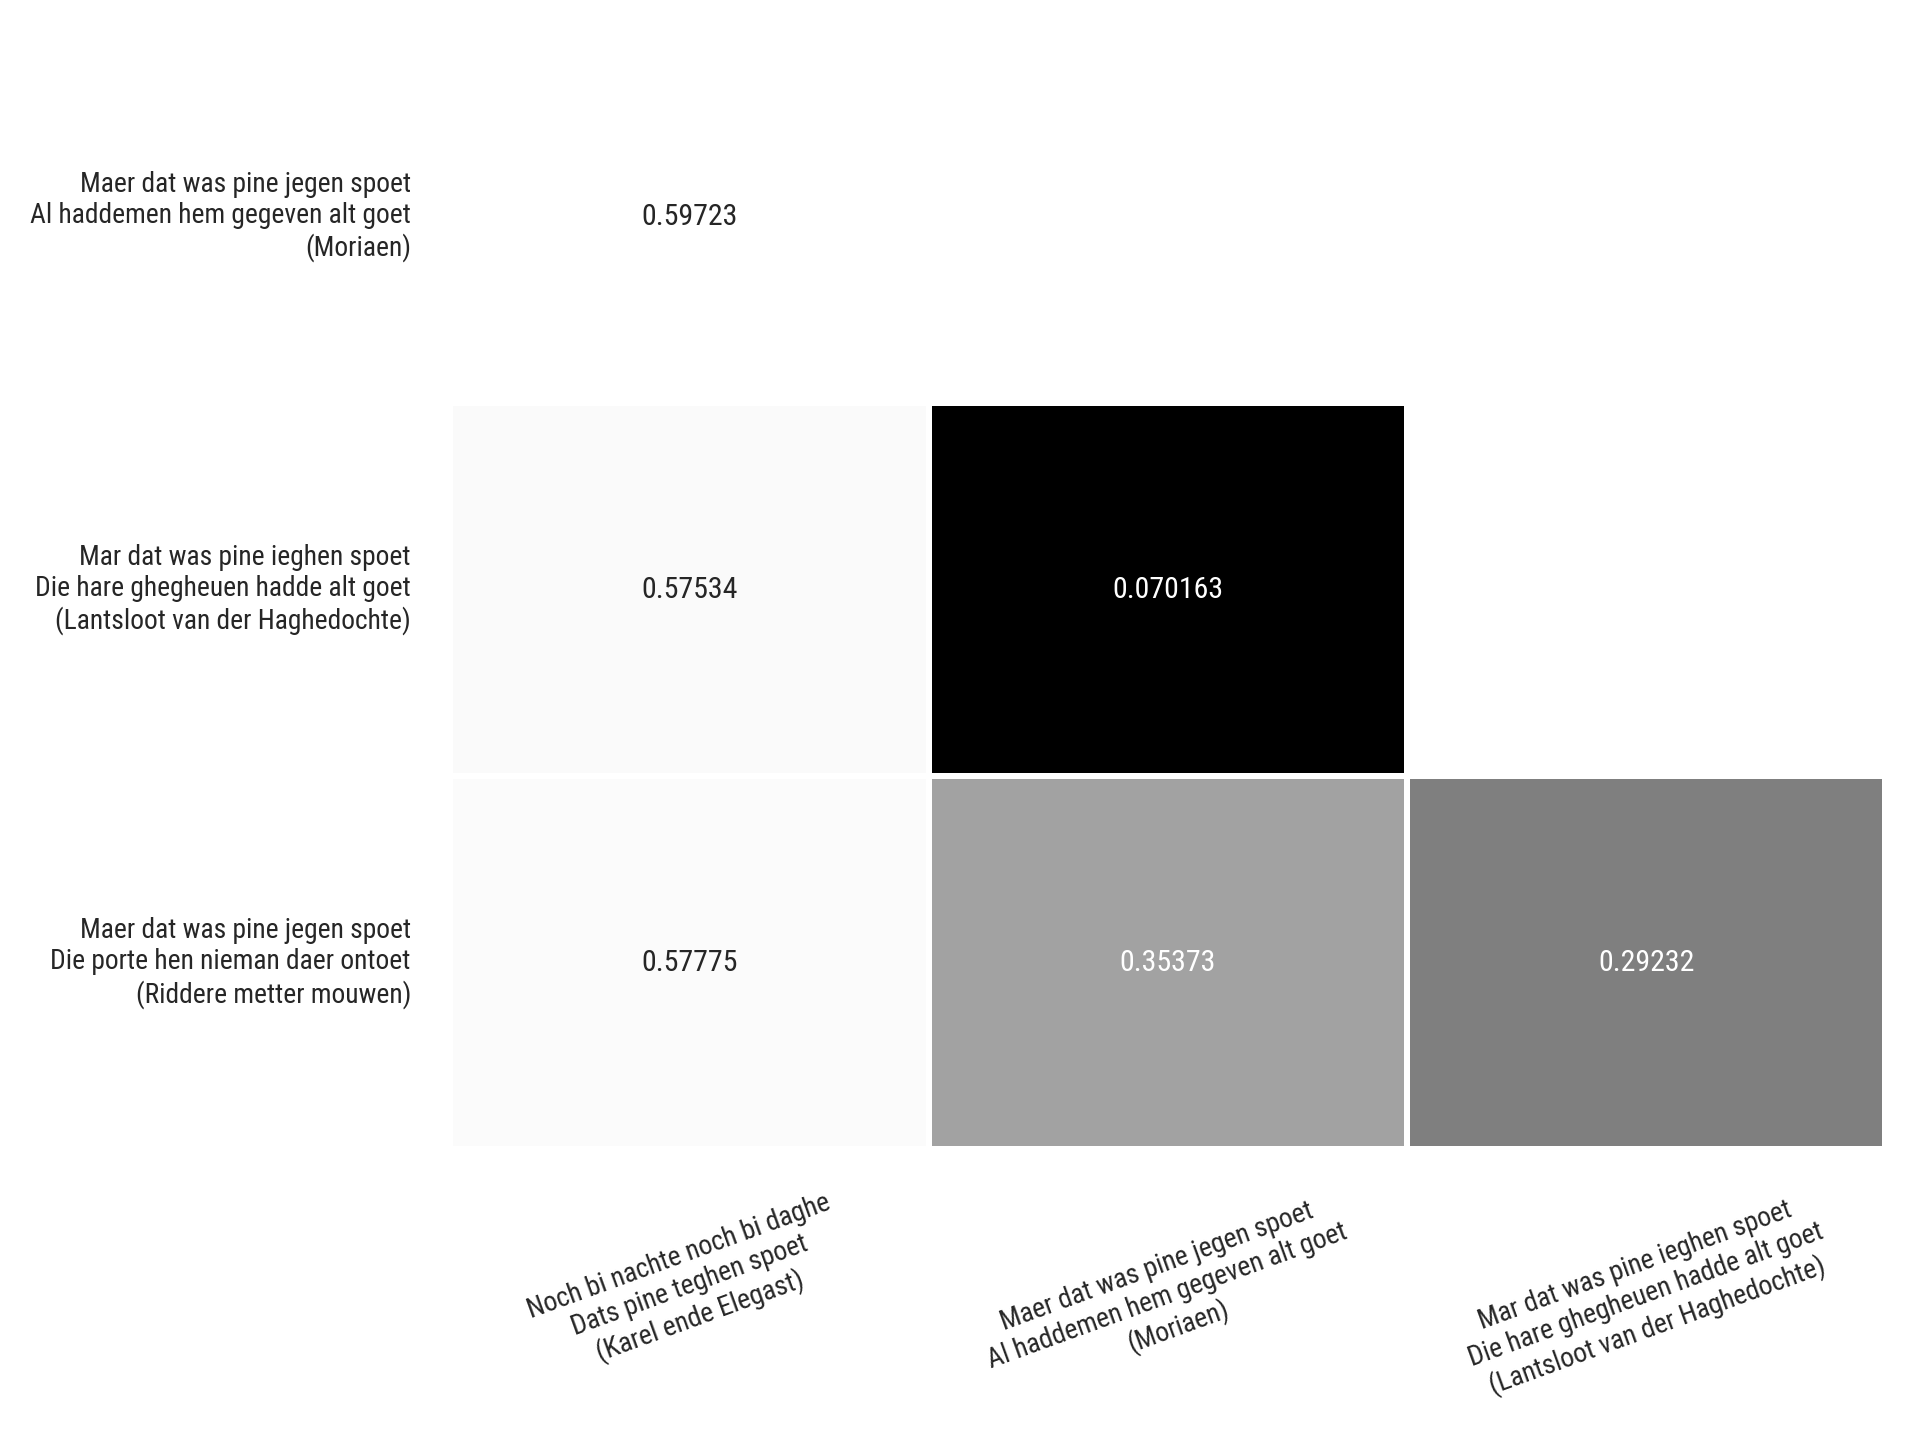

In [23]:
small_x = vec.transform(targets['lemmas']).toarray() + .15 * vec.transform(targets['rhyme']).toarray()
distances = squareform(pdist(small_x, metric='cosine'))
np.fill_diagonal(distances, np.nan)
distances[np.triu_indices(4)] = np.nan
labels = targets['tokens']
labels = [l.replace(' / ', '\n') for l in labels]
labels = [f'{label}\n({title})' for label, title in zip(labels, targets['title'])]
distances = pd.DataFrame(distances, index=labels, columns=labels)
distances = distances.iloc[1:, :-1]
ax = sb.heatmap(distances, annot=True, cmap='Greys_r', cbar=False,
                linewidths=1, linecolor='white', fmt='.5g')
ax.tick_params(left=False, bottom=False)
for l in plt.gca().lines:
    l.set_alpha(0.3)
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(f'{fig_dir}/example_cosine.png');

In [24]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta.sample(5)

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks
225,mor-ele-61,Lantsloot van der Haghedochte,Dien hi harde lange voer Ende vernam van niemene boer:,Moriaen,Daer men met scepen ouer voer Ende daer verlosic al dat boer.,2,"Heeroma 1973b, Moriaen (II)",NaN
139,lan-ele-16,Lantsloot van der Haghedochte,ouer ene corte wile Datmen mochte ene halue mile Riden:,Karel ende Elegast,een langhe wile Datmen gaen mochte een mile.,2,"Heeroma 1973b, Moriaen (II)",NaN
126,lan-ele-12,Lantsloot van der Haghedochte,Sal ic v der wareit lyen:,Moriaen,Salic v der waerheit lien.,1,"Heeroma 1973b, Moriaen (II)",NaN
192,lan-ele-55,Lantsloot van der Haghedochte,binnen enen foreeste Dat alre wideste dat alre meeste Dat men ierghent wiste:,Moriaen,Hets een foreest...Dat alre meeste datmen weet.,3,"Heeroma 1973b, Moriaen (II)",NaN
138,lan-ele-16,Moriaen,Binnen also corter wile Alse te ridene ene mile,Karel ende Elegast,een langhe wile Datmen gaen mochte een mile.,2,"Heeroma 1973b, Moriaen (II)",NaN


Determine rhyme weight with no restrictions on vocabulary size, except for `min_df=2`:

In [25]:
vec = TfidfVectorizer(max_features=None, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])

In [26]:
def precision_recall(df, meta, vec, rhyme_weight=.15):
    titles = set(list(meta['source']) + list(meta['target']))
    relevances, distances = [], []

    for t1, t2 in product(titles, titles):
        if t1 == t2:
            continue

        m = meta[meta['verse-length'] >= 2]
        m = m[(m['source'] == t1) | (m['source'] == t2)]
        m = m[(m['target'] == t1) | (m['target'] == t2)]

        if not len(m):
            continue

        A = df[(~df['intertext'].isna()) & (df['title'] == t1)]
        B = df[df['title'] == t2]

        AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
        BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

        all_distances = pairwise_distances(AX, BX, metric='cosine')

        for a_idx, (_, a) in enumerate(A.iterrows()):
            distances.extend(all_distances[a_idx])
            relevances.extend((B['intertext'] == a['intertext']).astype(int))
    
    return relevances, distances

relevances, distances = precision_recall(df, meta, vec, rhyme_weight=0)

Max(F1)=0.3528 voor afstand=0.4998


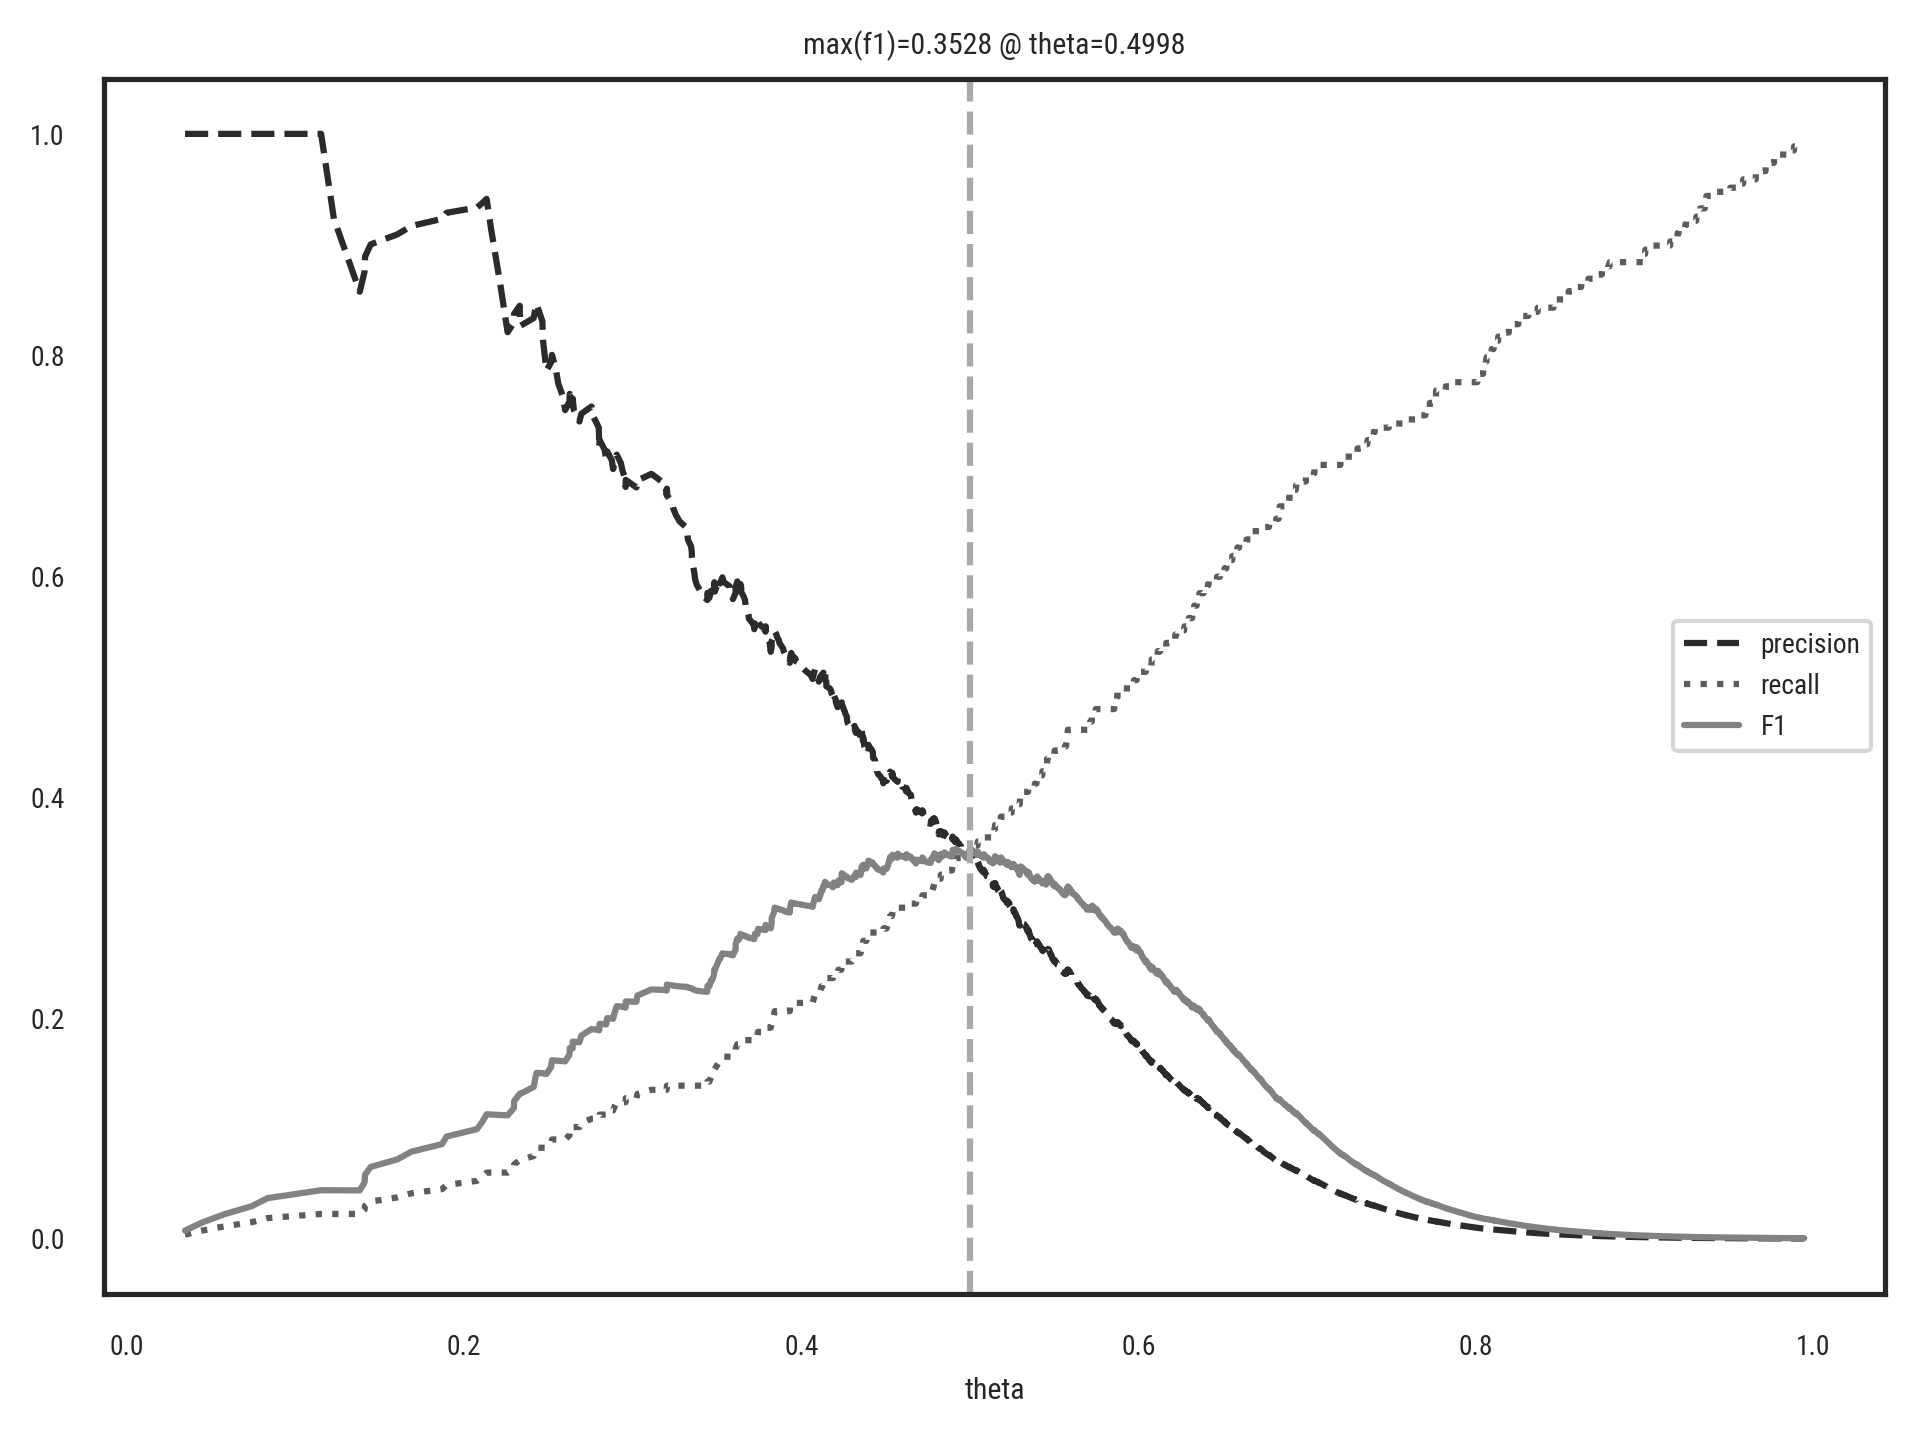

In [ ]:
def precision_recall_curve_distances(y_true, distances):
    y_true = np.array(y_true)
    distances = np.array(distances)
    
    desc_score_indices = np.argsort(distances)
    y_true = y_true[desc_score_indices]
    distinct_value_indices = np.where(np.diff(distances[desc_score_indices]))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]
    
    # Accumulate true positives and false positives
    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    precisions = tps / (tps + fps)
    recalls = tps / tps[-1]
    thresholds = distances[desc_score_indices][threshold_idxs]
    
    thresholds = thresholds[:-1]
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    
    return precisions, recalls, thresholds

precisions, recalls, thresholds = precision_recall_curve_distances(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)
max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]

print(f'Max(F1)={round(max_f1, 4)} voor afstand < {round(max_f1_th, 4)}')

plt.plot(thresholds, precisions, label='precision', ls='dashed')
plt.plot(thresholds, recalls, label='recall', ls='dotted')
plt.plot(thresholds, f1s, label='F1', ls='solid')
plt.axvline(max_f1_th, c='darkgrey', ls='--')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout();


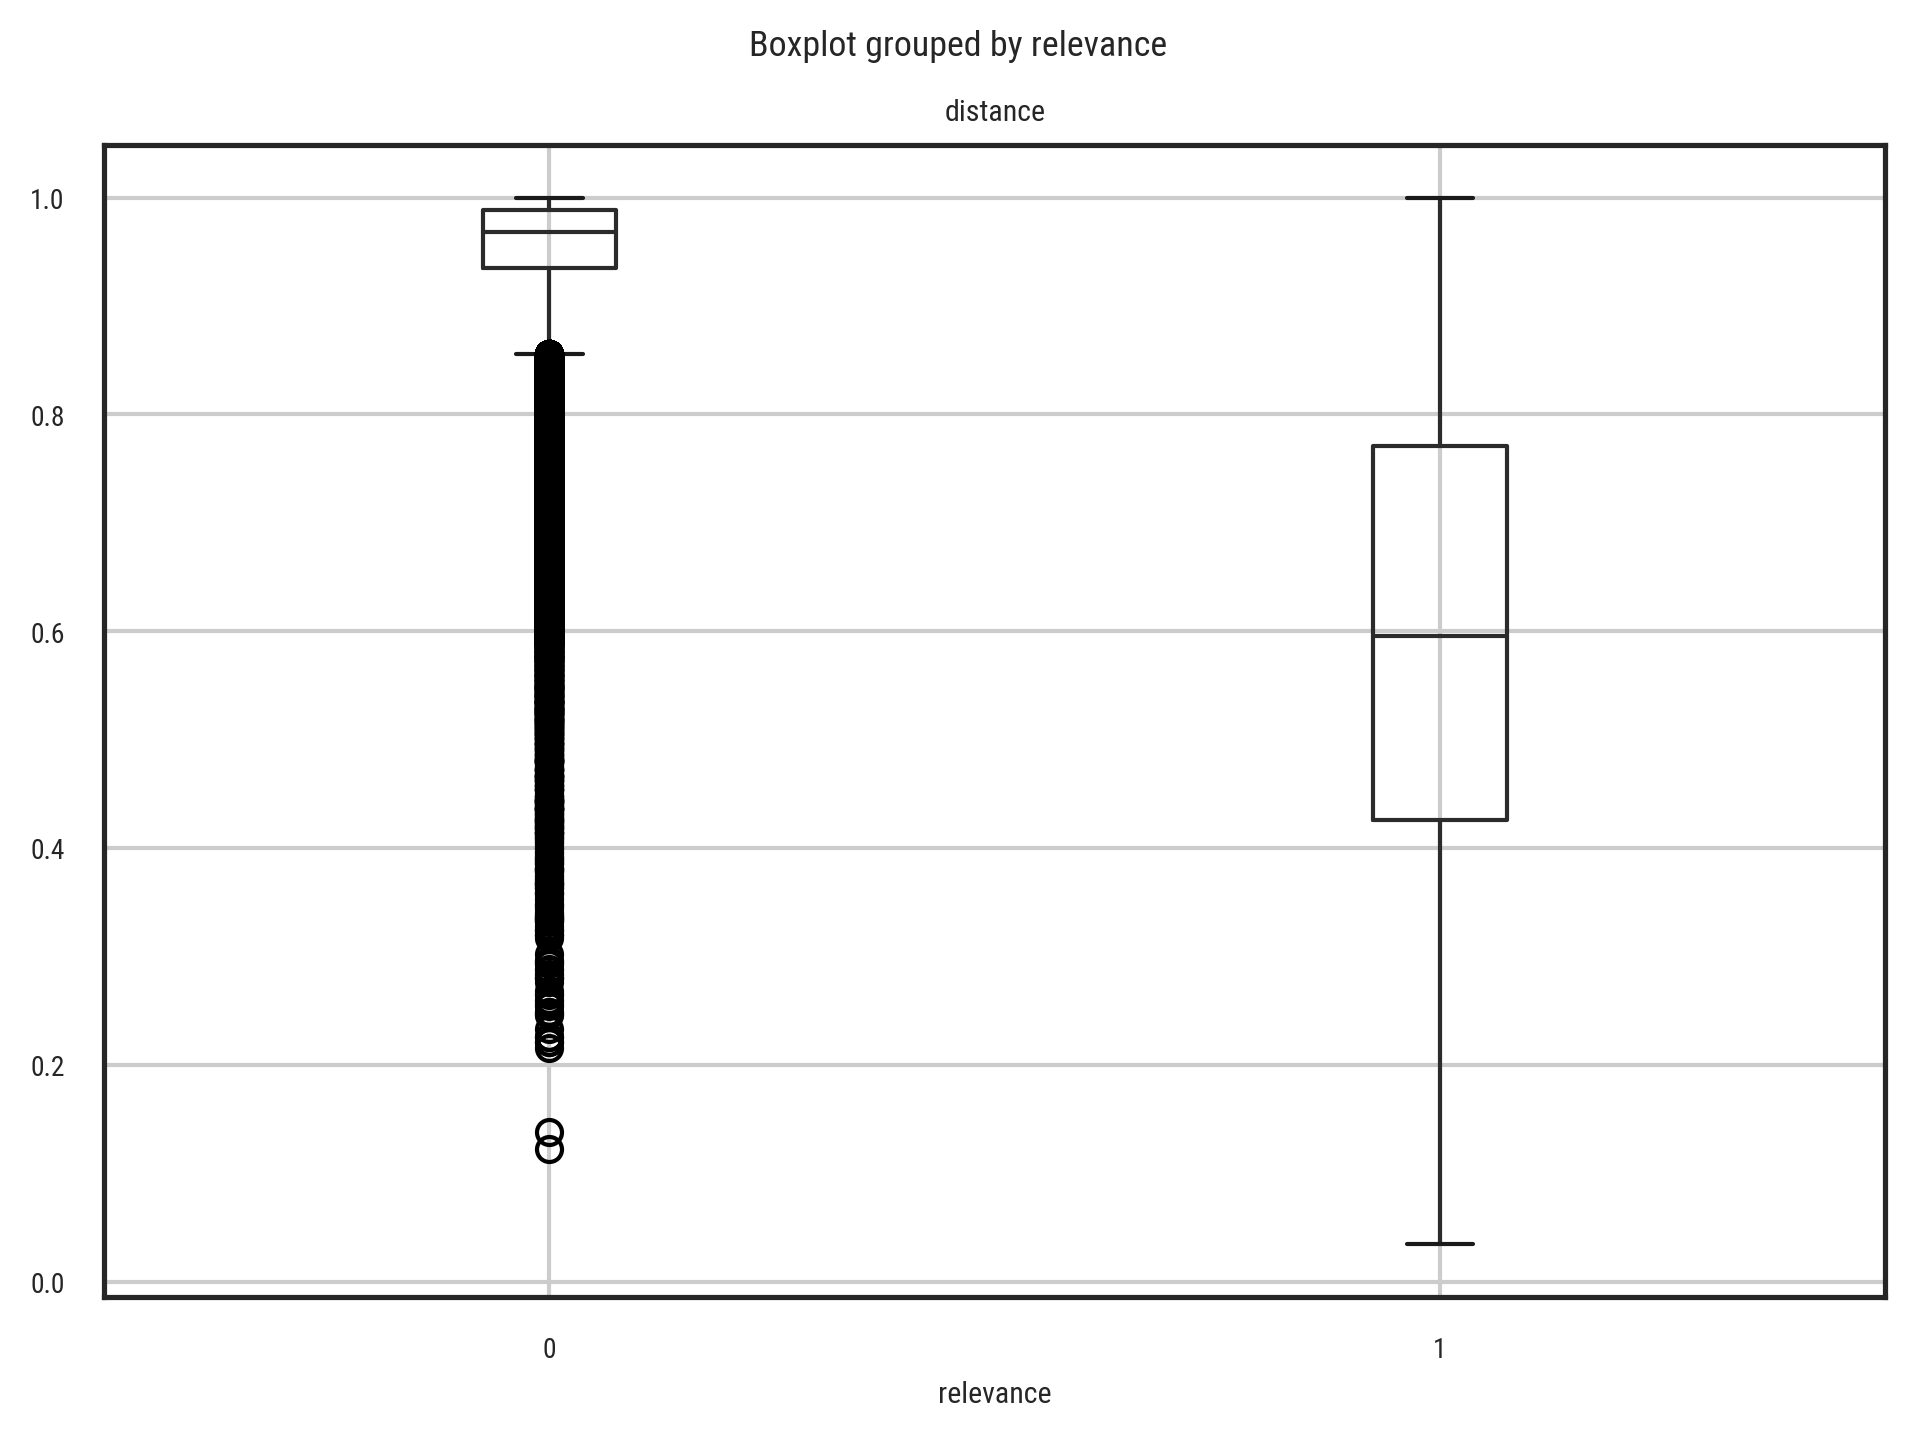

In [28]:
res_df = pd.DataFrame(zip(distances, relevances), columns=('distance', 'relevance'))
res_df.boxplot('distance', 'relevance')
plt.tight_layout();

### Calibrate parameters

##### 1. Rhyme weight

100%|██████████| 50/50 [02:14<00:00,  2.68s/it]


optimal rhyme weight: 0.1693877551020408


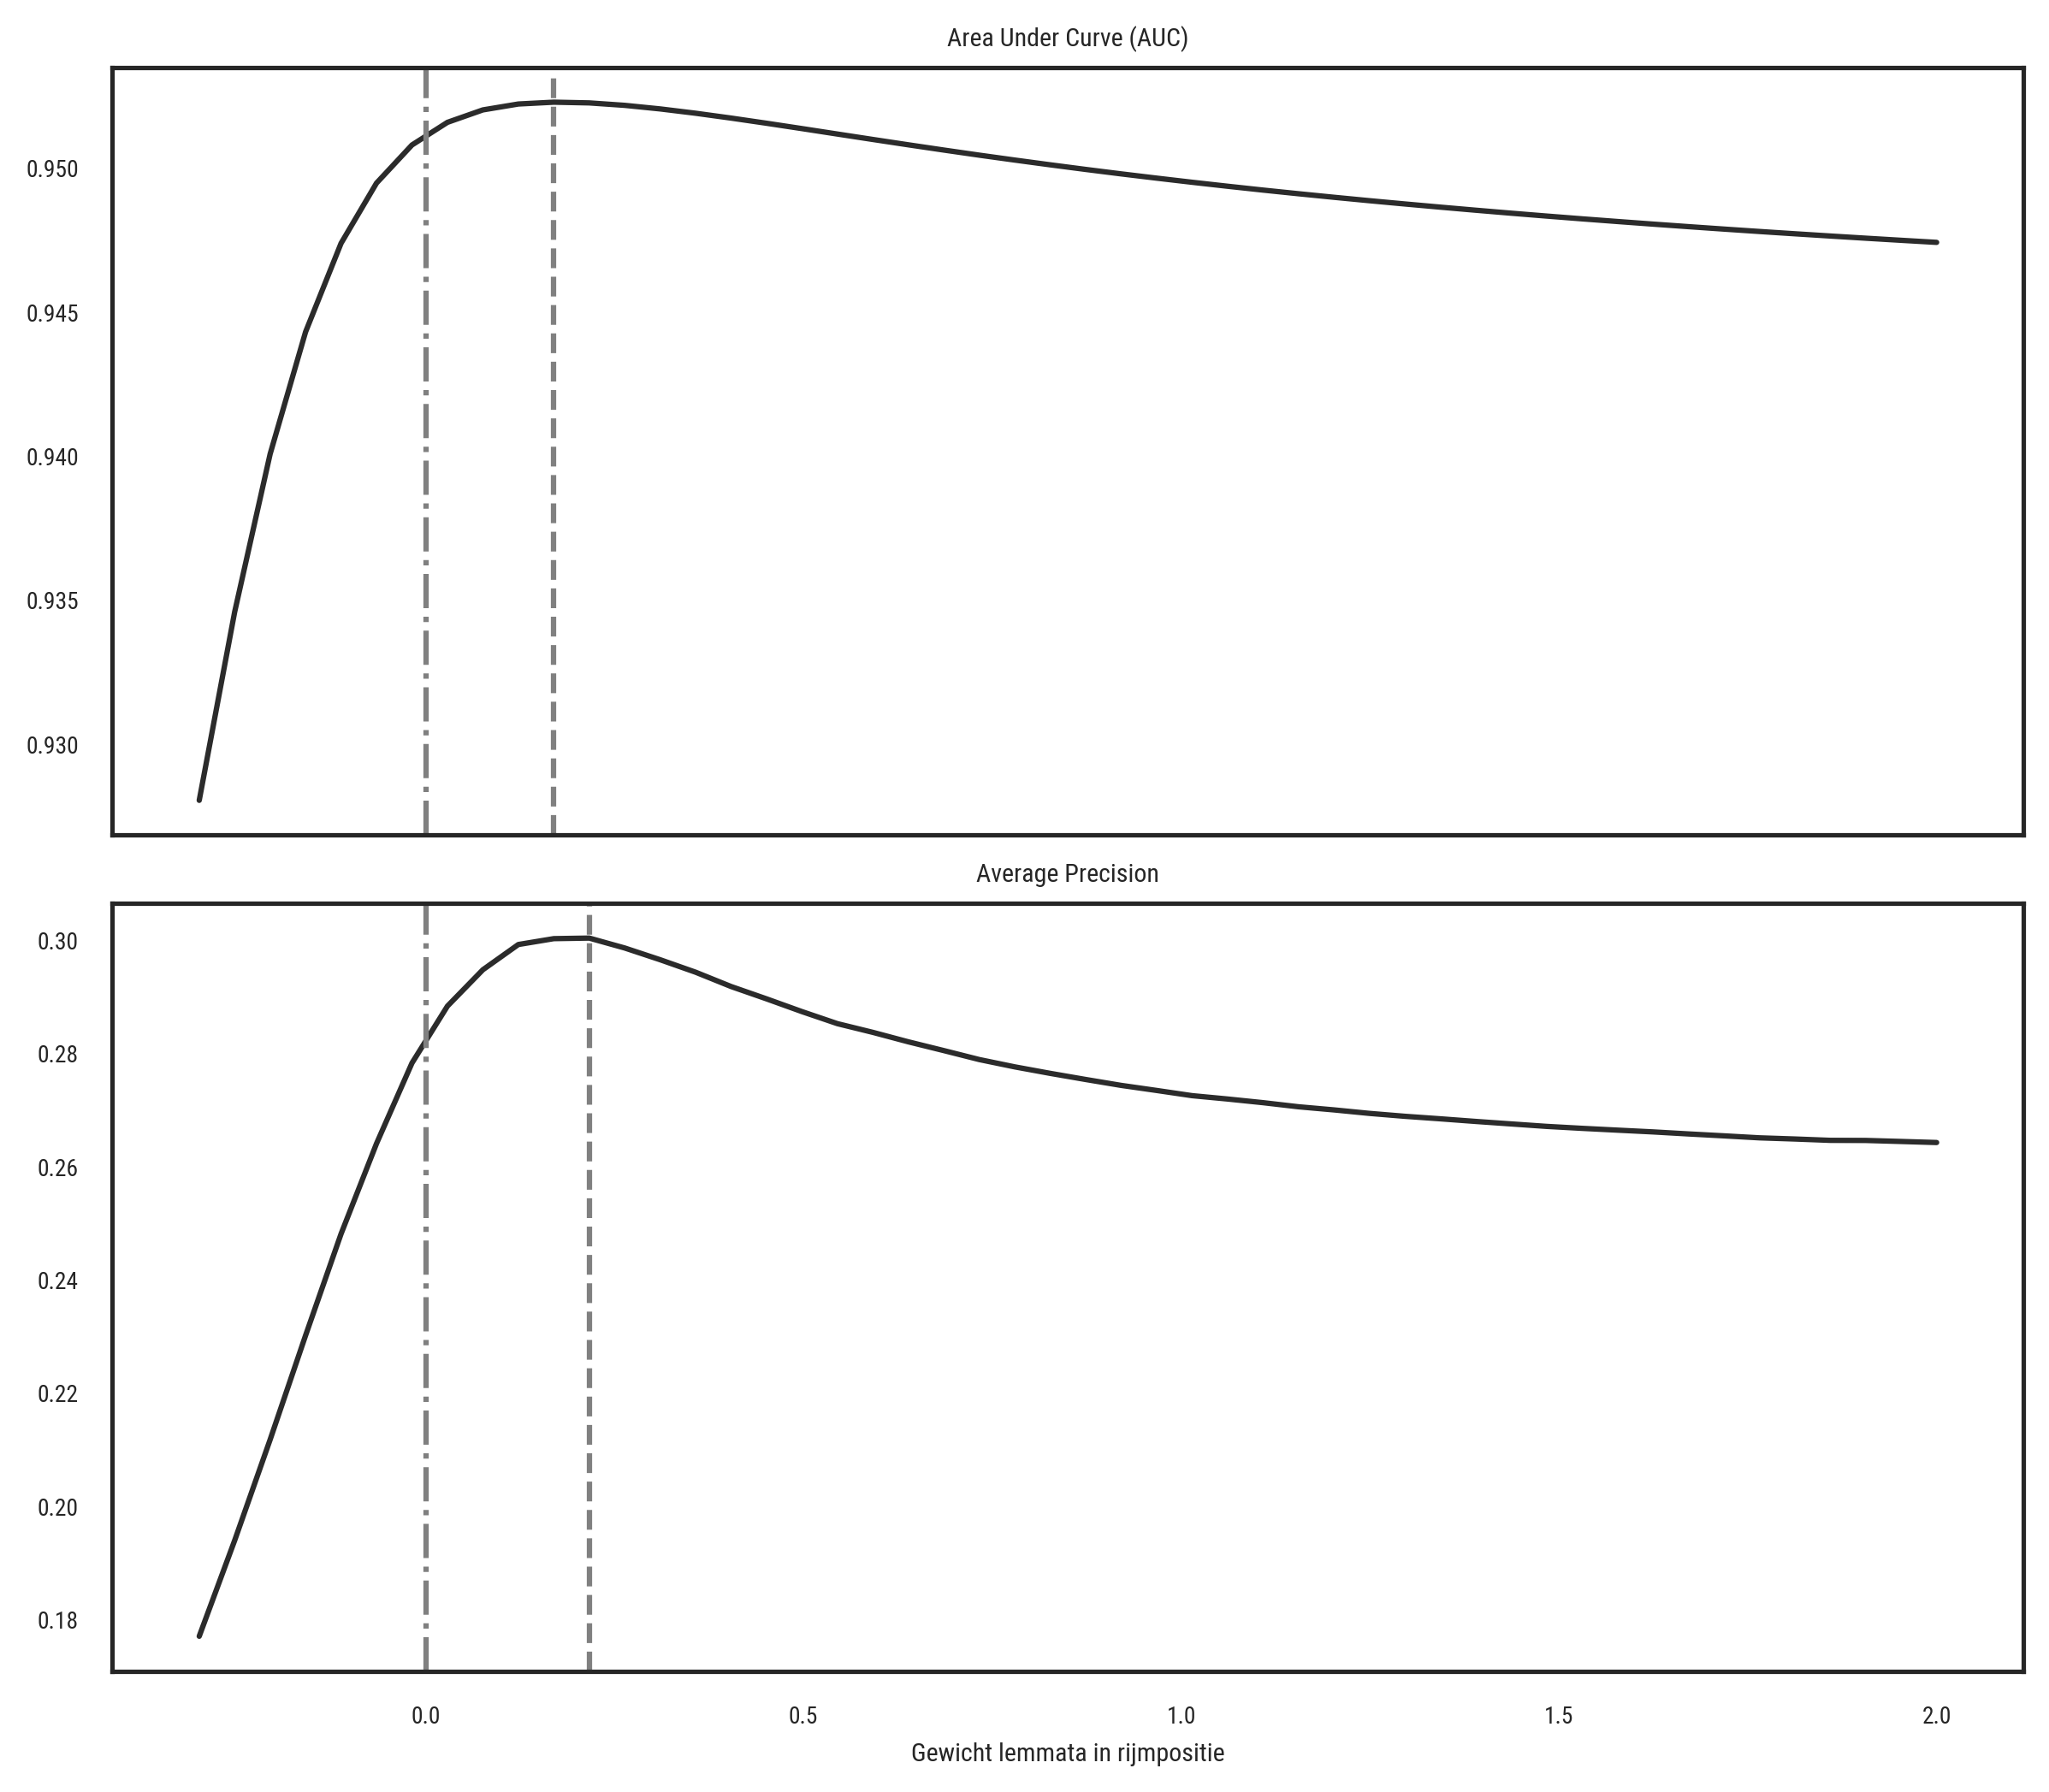

In [29]:
scores = []
# also negative weight for demonstration purposes:
rhyme_weights = tuple(np.linspace(-.3, 2.0, 50))

for rhyme_weight in tqdm(rhyme_weights):
    relevances, distances = precision_recall(df, meta, vec, rhyme_weight=rhyme_weight)
    distances = 1 - np.array(distances) # take complement of distances
    auc = roc_auc_score(relevances, distances)
    av_prec = average_precision_score(relevances, distances)
    scores.append((rhyme_weight, auc, av_prec))

scores = pd.DataFrame(scores, columns=('rhyme weight', 'AUC', 'AV-PREC'))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7))

# AUC plot
scores.plot('rhyme weight', 'AUC', ax=ax1, legend=False)
ax1.axvline(0, ls='-.', c='grey')
ax1.axvline(scores.iloc[scores['AUC'].idxmax()]['rhyme weight'], ls='--', c='grey')
ax1.set_title('Area Under Curve (AUC)')

# Average Precision plot
scores.plot('rhyme weight', 'AV-PREC', ax=ax2, legend=False)
ax2.axvline(0, ls='-.', c='grey')
ax2.axvline(scores.iloc[scores['AV-PREC'].idxmax()]['rhyme weight'], ls='--', c='grey')
ax2.set_title('Average Precision')

plt.xlabel('Gewicht lemmata in rijmpositie')

plt.tight_layout()
plt.savefig(f'{fig_dir}/rhyme_weight.png')

optim_rw = scores.iloc[scores['AUC'].idxmax()]['rhyme weight']
print('optimal rhyme weight:', optim_rw)

##### 2. Vocabulary size (and TF vs TF-IDF)

In [30]:
vec = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None,
                      min_df=2, max_features=None).fit(df['lemmas'])
print(len(vec.get_feature_names_out()))

scores = []

vocab_sizes = list(range(500, 41000, 500))
parametrizations = {
                    'TF-IDF': {'min_df': 2},
                    'TF': {'use_idf': False, 'min_df': 2},
                    }

for vocab_size in tqdm(vocab_sizes):
    for param_name, param in parametrizations.items():
        param['max_features'] = vocab_size
        vec = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None, **param)
        vec.fit(df['lemmas'])
        relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
        distances = 1 - np.array(distances)
        auc = roc_auc_score(relevances, distances)
        av_prec = average_precision_score(relevances, distances)
        scores.append((param_name, vocab_size, auc, av_prec))

40262


100%|██████████| 81/81 [16:02<00:00, 11.88s/it]


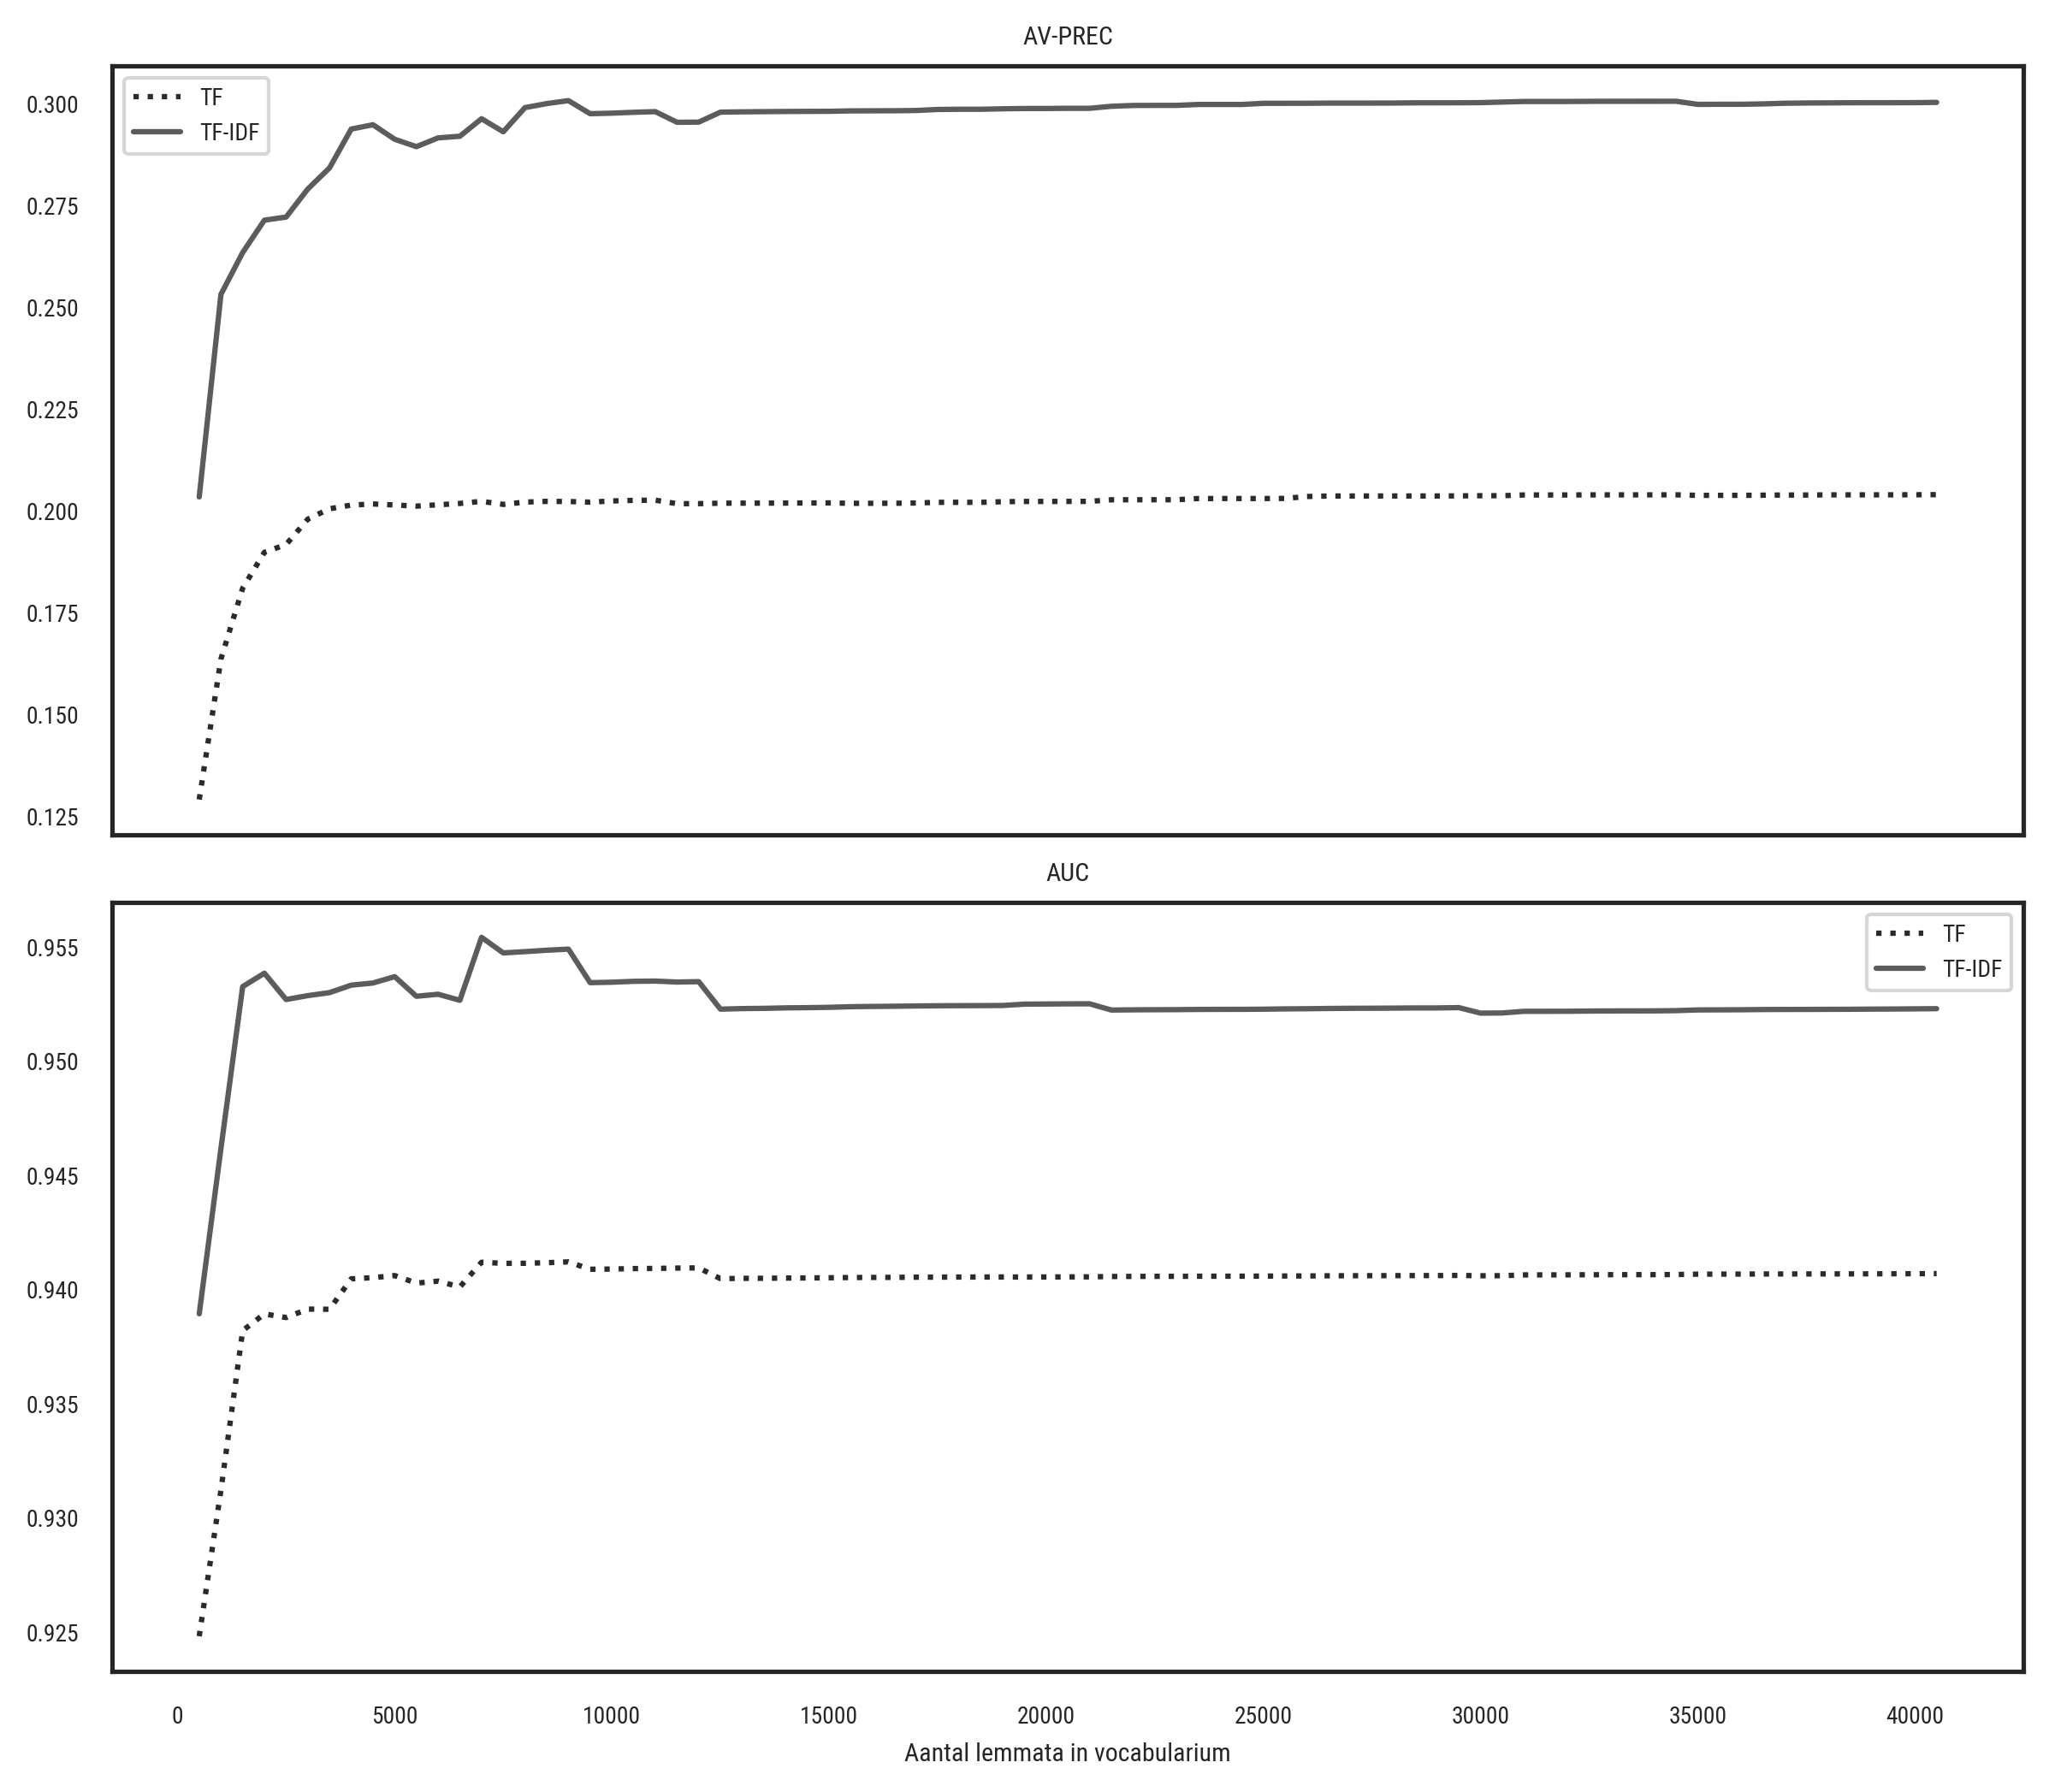

In [31]:
scores = pd.DataFrame(scores, columns=('param', 'vocab_size', 'AUC', 'AV-PREC'))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7))

# For AV-PREC plot
for i, (p, gr) in enumerate(scores.groupby('param')):
    linestyle = ':' if i == 0 else '-'  # dotted for first group, solid for others
    gr.plot('vocab_size', 'AV-PREC', label=p, ax=ax1, linestyle=linestyle)
ax1.set_title('AV-PREC')

# For AUC plot
for i, (p, gr) in enumerate(scores.groupby('param')):
    linestyle = ':' if i == 0 else '-'  # dotted for first group, solid for others
    gr.plot('vocab_size', 'AUC', label=p, ax=ax2, linestyle=linestyle)
ax2.set_title('AUC')

plt.xlabel('Aantal lemmata in vocabularium')

plt.tight_layout()
plt.savefig(f'{fig_dir}/vocab_size.png');


We use the product of the two scores, Area-Under-the-Curve (AUC) and average precision, to select the optimal vocabulary size:

In [32]:
scores['comb'] = scores['AUC'] * scores['AV-PREC']
optim_vs = scores.iloc[scores['AUC'].idxmax()]
display(optim_vs)
optim_vs = optim_vs['vocab_size']

param         TF-IDF  
vocab_size    7000    
AUC           0.955417
AV-PREC       0.296306
comb          0.283096
Name: 26, dtype: object

## Final threshold

Max(F1)=0.3622 voor afstand=0.4217


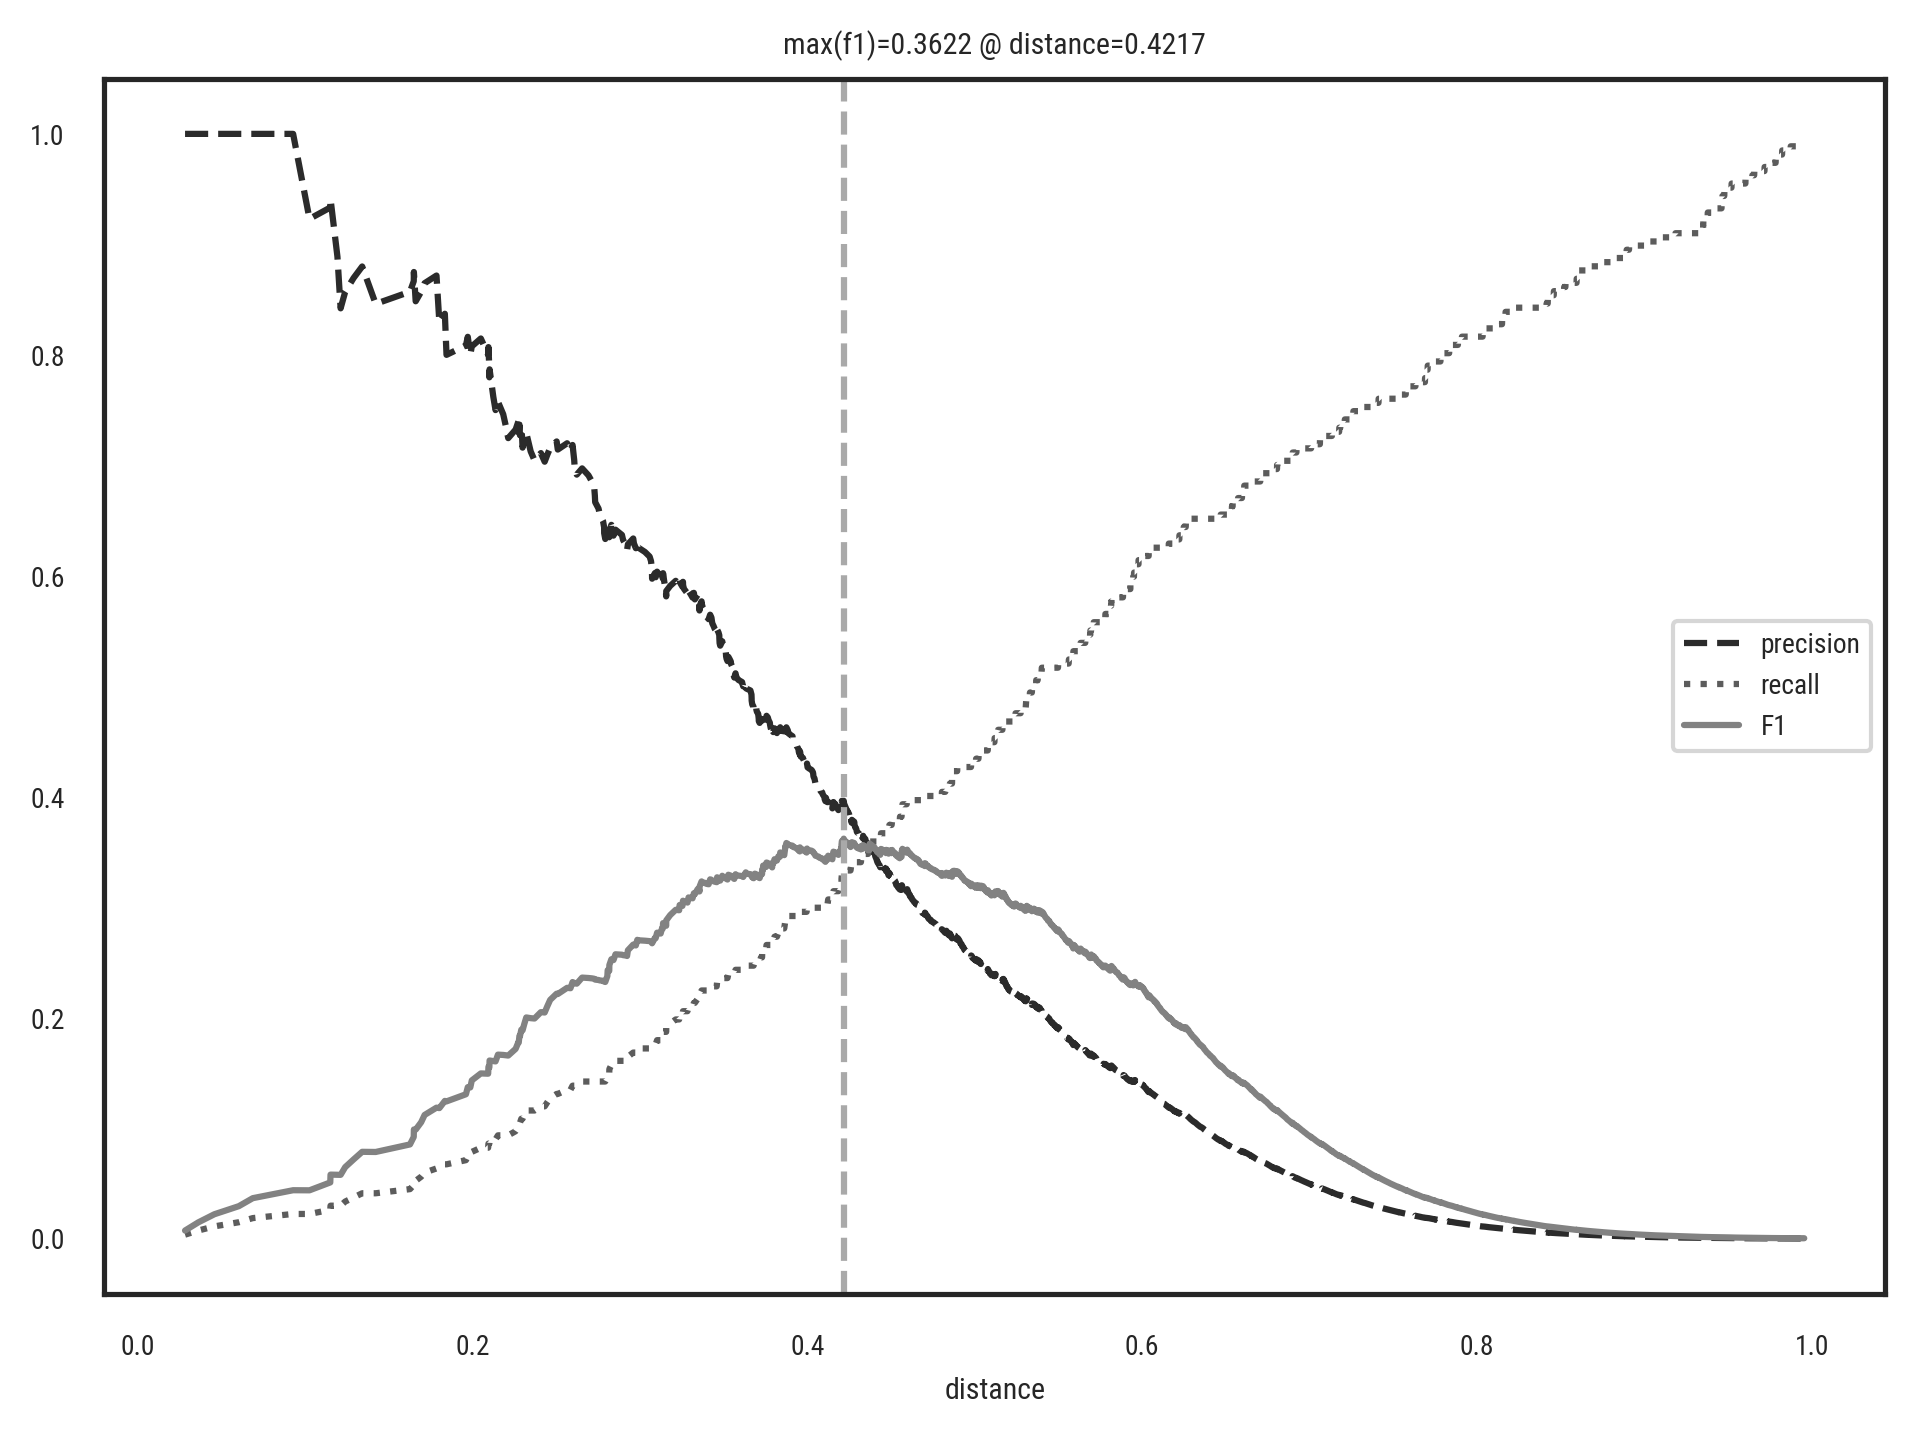

In [ ]:
vec = TfidfVectorizer(max_features=optim_vs, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])

relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
precisions, recalls, thresholds = precision_recall_curve_distances(relevances, distances)

# Calculate F1 scores - arrays should now be aligned
f1s = (2 * precisions * recalls) / (precisions + recalls)
max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]

print(f'Max(F1)={round(max_f1, 4)} voor afstand < {round(max_f1_th, 4)}')

# Plot - no need for [:-1] slicing since arrays are already aligned
plt.plot(thresholds, precisions, label='precision', ls='dashed')
plt.plot(thresholds, recalls, label='recall', ls='dotted')
plt.plot(thresholds, f1s, label='F1', ls='solid')
plt.axvline(max_f1_th, c='darkgrey', ls='--')
plt.gca().set_xlabel('distance')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ distance={round(max_f1_th, 4)}')
plt.tight_layout()
plt.savefig(f'{fig_dir}/threshold.png')

We've set these values:

In [34]:
print('optim_vs =', optim_vs)
print('optim_rw =', optim_rw)
print('optim_th =', max_f1_th)

optim_vs = 7000
optim_rw = 0.1693877551020408
optim_th = 0.4216533756862457
